In [1]:
# IMPORTS

#---------------------------------------
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from scipy import stats
from scipy.integrate import quad
from scipy.optimize.elementwise import find_minimum
import pickle
import os
from tqdm import tqdm
import time

In [222]:
# Plots customization

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20

mpl.rcParams['lines.linewidth'] = 3

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['xtick.minor.pad'] = 4.5

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['ytick.minor.pad'] = 4.5

mpl.rcParams['legend.frameon'] = False

In [223]:
# COORDINATES FUNCTIONS

#----------------------------------------------------------------
# Returns the 3D vector (x, y, z) correspoding to the spherical_coordinates (r, theta, phi)
# Imput is strictly a matrix of shape (N, 3), where N is the number of points to convert
# Be careful when N = 1 (shape (3,)): you can use np.expand_dims(array, axis=0)
# or add manually the dimension
def spherical_to_cartesian(spherical_coordinates):
    r = spherical_coordinates[:, 0]
    theta = spherical_coordinates[:, 1]
    phi = spherical_coordinates[:, 2]

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # Floating point precision would not give exact results around zeros of goniometric functions
    #
    # Return the result with the same shape of the input
    return np.stack([x, y, z], axis=1)

In [224]:
# PDF SAMPLING AND PLOTTING FUNCTIONS

#---------------------------------------------------------
# Compute a given PDF
#
# pdf: must be a callable that accepts x_grid as first positional parameter
# x_grid: the values over which the pdf has to be evaluated
# norm: whether to normalize numerically the PDF or not
# additional parameters are passed to pdf() through kwargs
def pdf_compute(pdf, x_grid, norm=False, **kwargs):
    y_pdf = pdf(x_grid, **kwargs)

    # Normalise the PDF if required
    if norm:
        norm = np.trapezoid(y_pdf, x_grid)
        y_pdf = y_pdf / norm
    
    return y_pdf

# Compute numerically the CDF of a given PDF along the x_grid
# The CDF is computed using the np.trapz() method
# Be aware of the limits of of np.trapz()
#
# parameters: see pdf_compute()
# norm: whether to normalize numerically the PDF or not
#       before computing the CDF
def cdf_compute_num(pdf, x_grid, norm=False, **kwargs):
    # Compute the pdf at each grid point
    y_pdf = pdf(x_grid, **kwargs)

    # Normalise the PDF if required
    if norm:
        norm = np.trapezoid(y_pdf, x_grid)
        y_pdf = y_pdf / norm

    # Compute the CDF by taking the cumulative integral on the grid points
    # array[:n] gives the first n terms of the array
    return np.array([np.trapezoid(y_pdf[:i+1], x_grid[:i+1]) for i in range(len(x_grid))])

# Compute a given PPF
#
# ppf: must be a callable that accepts P_grid as first positional parameter
# P_grid: the values over which the ppf has to be evaluated
#         They should be uniformly distributed random numbers between 0 and 1
# There is no norm parameter here because I hope that if you are lucky enough to have the CDF
# then it doens't need any adjustement (in reality I have no idea how to treat it at the present time,
# but this is a PDF oriented notebook afterall)
def ppf_compute(ppf, P_grid, **kwargs):
    return ppf(P_grid, **kwargs)

# A plotting utility to visualize a given PDF
#
# Same parameters as above plus the styling ones
#
# Returns the computed PDF to make the plot
def pdf_plotter(pdf, x_grid, norm=False,
                figsize=(12, 6), x_scale='linear', y_scale='linear',
                color=None,
                **kwargs):
    # Compute the PDF
    y_grid = pdf_compute(pdf, x_grid, norm=norm, **kwargs)

    # Plot the PDF
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(pdf.__name__)

    ax.plot(x_grid, y_grid, color=color)

    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)

    plt.show()

    # Return the computed PDF
    return y_grid

# A function that samples from a given PDF by performing
# a REJECTION SAMPLING technique
#
# pdf: the PDF from which to sample
# x_min, x_max, y_min, y_max: boundary of the box in which the rejection sampling is performed.
#                             the box should enclose completely the given pdf on the y axis.
#                             Choose a reasonable extension on the x axis to make a good sampling.
#                             BE AWARE OF WHAT YOU ARE SAMPLING!!
# size: the number of points to be sampled
# verbose: whether to print or not some diagnostic during the execution
# **kwargs: additional parameters to be passed to pdf()
#
# Returns the points sampled from the given PDF
def pdf_sampler(pdf,
                x_min, x_max, y_min, y_max,
                size=100, verbose=False, **kwargs):
    # Initialise the iteration counter
    iter_counter = 0

    # Initialise the array of sampled points and its lenght
    sampled_x = np.zeros(0)
    n_sample = len(sampled_x) # Number of sampled points
    
    # Sample until the desired number of points is reached
    while n_sample < size:
        # Generate (size - n_sample) uniformly distributed random numbers between 0 and 1
        x = np.random.uniform(x_min, x_max, size - n_sample)
        y = np.random.uniform(y_min, y_max, size - n_sample)

        # Get the PDF value for each of the x points
        # pdf_computed() here is not used to prevent an accidental parsing
        # of the norm parameter. Since 'x' can be very small in size normalizing is dangerous
        y_bound = pdf(x, **kwargs)

        # Append to the result array every x such that its y is smalle than its PDF
        # The '=' sign is necessary to account for limiting cases of constant pdf() functions
        sampled_x = np.append(sampled_x, x[y<=y_bound])

        # Compute the sampling efficiency of the performed iteration
        # i.e. how many point have been accepted out of the total generated (in the last iteration)
        samp_eff = 100 * len(x[y<=y_bound]) / (size - n_sample)

        # Update the number of sampled points and the iteration counter
        n_sample = len(sampled_x)
        iter_counter +=1

        # Print the diagnostic if required
        if verbose:
            # Build a diagnostic string
            diagnostic_str = ("Iteration {0}\n\n".format(iter_counter) +
                              "Sampling efficiency: {0} %\n".format(np.format_float_positional(samp_eff, 3)) +
                              "Sampled points: {0}\n".format(len(x[y<=y_bound])) +
                              "Progress: {0} out of {1}\n\n".format(n_sample, size))
            print(diagnostic_str)

    # Return the sampled points
    return sampled_x

# A plotting utility to visualize the sampled PDF
#
# pdf, x_grid: see pdf_plotter()
# sampled_x: the points sampled from the PDF (likely by pdf_sampler())
# norm: whether to normalize numerically the PDF or not
# quantiles: quantile lines to overplot on the samples distribution
# q_color: color of the quantiles
# q_styles: linestyle for each quantile
# styling parameters. 
# x_scale, y_scale: axis scales
# scale_unit: If given, the x axis will use scale_unit as the unit of the axis
# **kwargs: additional parameters to be passed to pdf()
def sampler_diagnostic_plot(pdf, x_grid, sampled_x, norm=False,
                            quantiles=[0.16, 0.5, 0.84], q_color='black', q_styles=[':', '-.', '--'],
                            figsize=(10, 8), bins='auto', histtype='stepfilled', color_plot=None, color_hist=None,
                            x_label=None, y_label=None,
                            x_scale='linear', y_scale='linear',
                            **kwargs):
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Plot the PDF
    ax.plot(x_grid, pdf_compute(pdf, x_grid, norm=norm, **kwargs), color=color_plot)

    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)

    # Plot the sampled PDF
    ax.hist(sampled_x, bins=bins, density=True, histtype=histtype, color=color_hist)

    # Compute and plot also some quantiles
    x_quantiles = np.quantile(sampled_x, quantiles)
    for q in range(len(quantiles)):
        ax.axvline(x_quantiles[q], color=q_color, linestyle=q_styles[q])

    return fig, ax

# A support function that genarates and returns support variables
#
# pdf: the PDF to use
# x_min, x_max: limits of the x_grid to be generated
# grid_n_points: number of points in the grid
# **kwargs: additional parameters to be passed to pdf()
#
# Returns a list: index 0: pdf
#                 index 1: [x_grid, y_grid]
#                 index 2: [x_min, y_min]
#                 index 3: [x_max, y_max]
#                 index 4: kwargs
def pdf_initialiser(pdf, x_min, x_max, grid_n_points=1000, **kwargs):
    x_grid = np.linspace(x_min, x_max, grid_n_points)
    y_grid = pdf(x_grid, **kwargs)

    y_min = np.min(y_grid)
    y_max = np.max(y_grid)

    return [pdf, [x_grid, y_grid], [x_min, y_min], [x_max, y_max], kwargs]

# Generates points in a sphere based on the given PDFs and their bounds
# pdf: the PDF to use
# bounds: list of 2 numbers: [min, max]
# size: the size of the sampling
# size_init: the size for the initialiser x_grid
#            Not important, here just for consistency
# pdf_args: dictionaries for additional arguments for the pdf() functions
#           Use dict(arg1=value1, arg2=value2, ...) to build them
def generate_spherical_points(pdf_r, r_bounds,
                              pdf_theta, theta_bounds,
                              pdf_phi, phi_bounds,
                              size=1, size_init=1000,
                              pdf_r_args={}, pdf_theta_args={}, pdf_phi_args={}):
    
    # Make ordered lists of the parameters
    pdf_list = [pdf_r, pdf_theta, pdf_phi]
    pdf_args_list = [pdf_r_args, pdf_theta_args, pdf_phi_args]
    bounds_list = [r_bounds, theta_bounds, phi_bounds]

    # Initialise all the PDF variables
    init_list = [pdf_initialiser(pdf_list[i], bounds_list[i][0], bounds_list[i][1],
                                 size_init, **pdf_args_list[i])
                                 for i in range(3)]

    # Sample from each PDF
    samples_list = [pdf_sampler(init_list[i][0],
                                init_list[i][2][0], init_list[i][3][0], init_list[i][2][1], init_list[i][3][1],
                                size=size, **init_list[i][4])
                                for i in range(3)]
    
    # Return the result as a (size, 3) shaped matrix
    return np.stack([samples_list[0], samples_list[1], samples_list[2]], axis=1)

# Computes the primitive of a function on a given grid:
# the integral of func from lower_limit to x for every x in x_grid or
# the integral of func from x to upper_limit for every x in x_grid
# Uses the quad() function from scipy
# func: the integrand, a callable whose first parameter is the independent variable
# x_grid: the grid on which the primitive is computed
# *kwargs: any positional parameter taken by func
# lower_limit, upper_limit: the integration limits. Must provide at least one and only one
def primitive_quad(func, x_grid, *kwargs, lower_limit=None, upper_limit=None):
    if (type(lower_limit) == type(None) and type(upper_limit) == type(None)) or\
        (type(lower_limit) != type(None) and type(upper_limit) != type(None)):
        raise ValueError("Specify limits or use quad directly for integration on fixed intervals")
    if type(upper_limit) != type(None):
        return np.array([quad(func, x_inf, upper_limit, args=kwargs)[0] for x_inf in x_grid])
    elif type(lower_limit) != type(None):
        return np.array([quad(func, lower_limit, x_up, args=kwargs)[0] for x_up in x_grid])

In [225]:
# PHYSICS FUNCTIONS

#-------------------------------------------------
# qt_vec[particle_index][cooridnate_index]
def get_qt_center_of_mass(qt_vec, m):
    return np.sum(qt_vec * m, axis=0) / (len(qt_vec) * m)

# MODIFIED NFW (G = 1)
#-------------------------------------------------
def NFW_rho(r, rho_0, R_s):
    x = r / R_s
    return rho_0 / (x * (1 + x) ** 2)

def rho(r, rho_0, R_s, R_vir):
    x = r / R_vir
    return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)

# value to be set to True if r is not iterable
# maybe I should rewrite it using the np.iterable() condition
# as I did for DF()
def mass(r, rho_0, R_s, R_vir, value=False):
    if value:
        return quad(lambda r: (4 * np.pi * r ** 2) * rho(r, rho_0, R_s, R_vir), 0, r)[0]
    else:
        return primitive_quad(lambda r, rho_0, R_s, R_vir: (4 * np.pi * r ** 2) * rho(r, rho_0, R_s, R_vir),
                              r, rho_0, R_s, R_vir, lower_limit=0)
    
def v_circ(r, rho_0, R_s, R_vir, value=False):
    return (mass(r, rho_0, R_s, R_vir, value) / r) ** 0.5

def potential(r, rho_0, R_s, R_vir, value=False):
    if value:
        return -(mass(r, rho_0, R_s, R_vir, value) / r +
                 4 * np.pi * quad(lambda r, rho_0, R_s, R_vir: r * rho(r, rho_0, R_s, R_vir),
                                  r, np.inf, args=(rho_0, R_s, R_vir))[0])
    else:
        return -(mass(r, rho_0, R_s, R_vir, value) / r +
                 4 * np.pi * primitive_quad(lambda r, rho_0, R_s, R_vir: r * rho(r, rho_0, R_s, R_vir),
                                            r, rho_0, R_s, R_vir, upper_limit=np.inf))

# Load the Distribution function model, if present
if os.path.exists("DF_model.pkl"):
    with open("DF_model.pkl", "rb") as model:
        kr = pickle.load(model)

# Distribution function f(E), where E = phi(r) + 0.5 * v^2 < 0
# The evaluation of this estimator is a bit expensive,
# therefore using it might take a while
def DF(E):
    if not np.iterable(E):
        return kr.predict([[E]])[0]
    else:
        return kr.predict(E[:, np.newaxis])

In [226]:
# DISTRIBUTION DEFINITIONS

#-------------------------------------------------
# Define there the proper distributions to be used for each variable

def pdf_r(r, rho_0, R_s, R_vir, M_tot):
    if not np.iterable(r):
        if r == 0:
            return 0
        else:
            return 4 * np.pi * r ** 2 * rho(r, rho_0, R_s, R_vir) / M_tot
    else:
        result = np.zeros(len(r))
        non_zero_mask = np.nonzero(r)
        result[non_zero_mask] =\
            4 * np.pi * r[non_zero_mask] ** 2 * rho(r[non_zero_mask], rho_0, R_s, R_vir) / M_tot
        return result

# The velocity PDF is radius dependent
# R is the radius for which the velocity pdf is computed
# The normalization would be achieved by dividing by rho(R),
# however I avoid it because the result would be affected by the precision of the DF
# I can normalize it numerically when needed
def pdf_v(v, R, rho_0, R_s, R_vir, phi_R=None):
    if phi_R == None:
        phi_R = potential(R, rho_0, R_s, R_vir, value=True)
        return 4 * np.pi * v ** 2 * DF(0.5 * v ** 2 + phi_R)
    else:
        return 4 * np.pi * v ** 2 * DF(0.5 * v ** 2 + phi_R)

def pdf_theta(theta):
    return np.sin(theta) / 2

def ppf_theta(P):
    return np.arccos(1 - 2 * P)

def pdf_phi(phi):
    return stats.uniform.pdf(phi, 0, 2 * np.pi)

def ppf_phi(P):
    return stats.uniform.ppf(P, 0, 2 * np.pi)

# Define the parameters of the distribution

In [227]:
# PARAMETERS OF THE DISTRIBUTION

#----------------------------------------------
t0 = 0 # Initial time. To be writed in the input_file
N = 10000 # Number of particles

rho_0 = 1
R_s = 1 # Scale radius
c = 25 # Concentration parameter
alpha = 10 # alpha * R_vir is the upper bound of the sampling
R_vir = c * R_s # Virial radius

M_tot = mass(np.inf, rho_0, R_s, R_vir, value=True) # Total mass of the distribution

# Sampling bounds for each variable
r_bounds = [0, alpha * R_vir]
theta_bounds = [0, np.pi]
phi_bounds = [0, 2 * np.pi]

m = M_tot / N # Mass of each particle

# Make an array with the masses of each particle
masses_array = [m for i in range(N)]

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_56311/4084278498.py:16: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


# Check that everything works

In [ ]:
# Wheter to save or not plots images
save_fig = False
dpi = 300

figures = []
figure_names = []

In [229]:
# Size of the sampling for the plots
size = 100000

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_56311/1920445523.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(


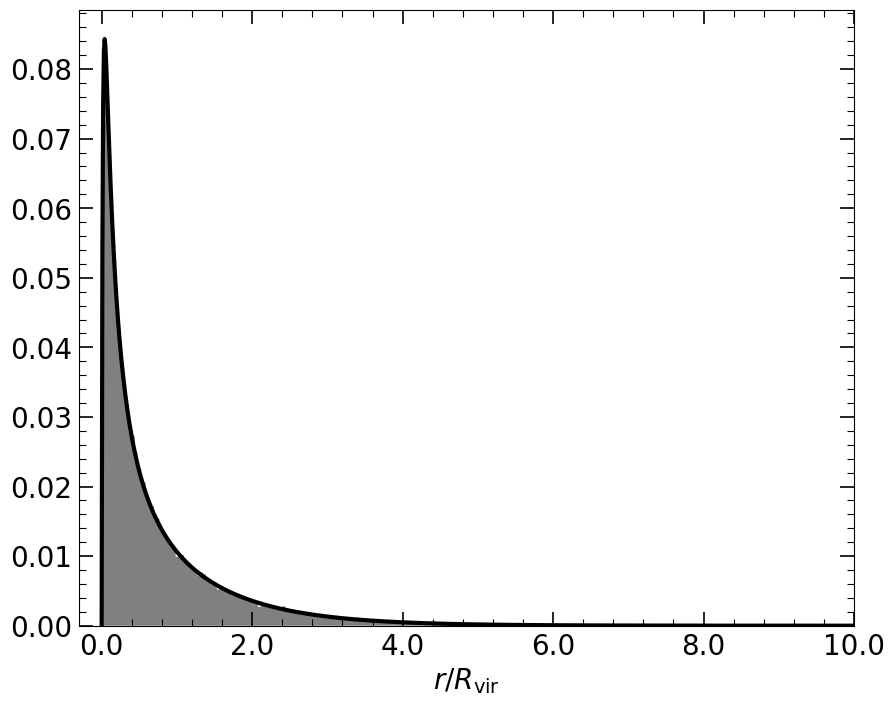

In [230]:
r_init = pdf_initialiser(pdf_r, r_bounds[0], r_bounds[1], rho_0=rho_0, R_s=R_s, R_vir=R_vir, M_tot=M_tot)

sampled_r = pdf_sampler(r_init[0],
                        r_init[2][0], r_init[3][0], r_init[2][1], r_init[3][1],
                        size=size, **r_init[4], verbose=False)
fig, ax = sampler_diagnostic_plot(r_init[0], r_init[1][0], sampled_x=sampled_r, **r_init[4],
                                  color_plot='black', color_hist='gray', x_label=r'$r / R_\text{vir}$', quantiles=[])

ax.set_xmargin(0.03)
ax.set_xlim(ax.get_xlim()[0], r_bounds[1])

# Rescale axis
ax.xaxis.set_major_formatter(ticker.FixedFormatter(
    ax.xaxis.get_major_locator()() / R_vir))

figures.append(fig)
figure_names.append('pdf_r')

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_56311/4084278498.py:16: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


Iteration 1

Sampling efficiency: 45.784 %
Sampled points: 45784
Progress: 45784 out of 100000


Iteration 2

Sampling efficiency: 45.509 %
Sampled points: 24673
Progress: 70457 out of 100000


Iteration 3

Sampling efficiency: 45.652 %
Sampled points: 13487
Progress: 83944 out of 100000


Iteration 4

Sampling efficiency: 46.325 %
Sampled points: 7438
Progress: 91382 out of 100000


Iteration 5

Sampling efficiency: 46.322 %
Sampled points: 3992
Progress: 95374 out of 100000


Iteration 6

Sampling efficiency: 46.649 %
Sampled points: 2158
Progress: 97532 out of 100000


Iteration 7

Sampling efficiency: 44.53 %
Sampled points: 1099
Progress: 98631 out of 100000


Iteration 8

Sampling efficiency: 45.873 %
Sampled points: 628
Progress: 99259 out of 100000


Iteration 9

Sampling efficiency: 45.614 %
Sampled points: 338
Progress: 99597 out of 100000


Iteration 10

Sampling efficiency: 44.913 %
Sampled points: 181
Progress: 99778 out of 100000


Iteration 11

Sampling efficiency: 49.55

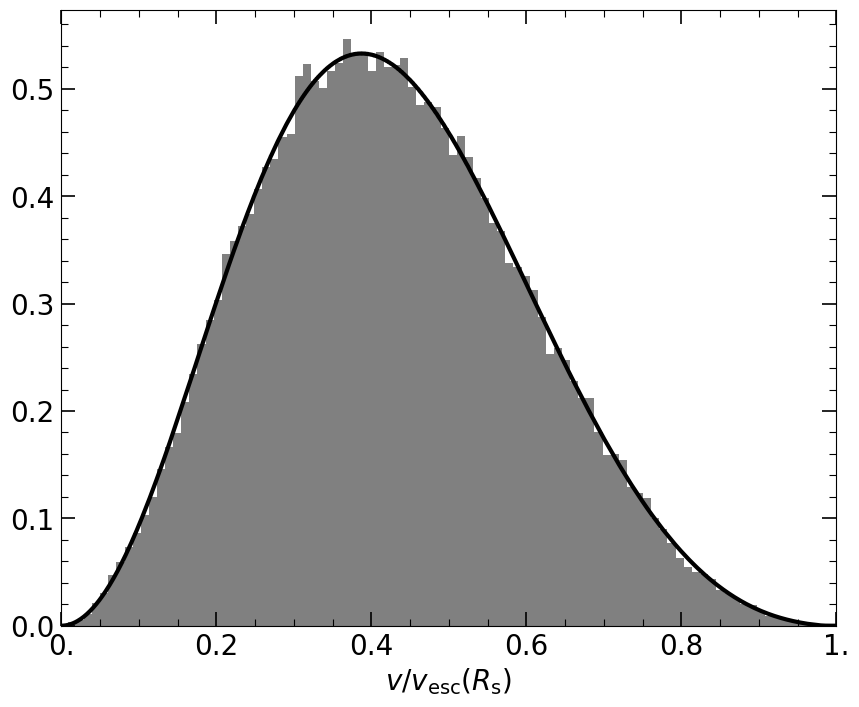

In [231]:
# The velocity PDF is radius dependent: choose a radius to plot it
# The implemented PDF is defined to be already normalized, but it is
# better to normalize it manually because of small errors in the DF
R_test = R_s
phi_R_test = potential(R_test, rho_0, R_s, R_vir, value=True)

v_init = pdf_initialiser(pdf_v, 0, (-2 * phi_R_test) ** 0.5,
                         R=R_test, rho_0=rho_0, R_s=R_s, R_vir=R_vir, phi_R=phi_R_test)

sampled_v = pdf_sampler(v_init[0],
                        v_init[2][0], v_init[3][0], v_init[2][1], v_init[3][1],
                        size=size, **v_init[4], verbose=True)
fig, ax = sampler_diagnostic_plot(v_init[0], v_init[1][0], sampled_x=sampled_v, norm=True, **v_init[4],
                                  color_plot='black', color_hist='gray', x_label=r'$v / v_\text{esc}(R_\text{s})$', quantiles=[])

ax.autoscale(axis='x', tight=True)

ax.xaxis.set_major_locator(ticker.FixedLocator(np.linspace(0, ax.get_xlim()[1], 5 + 1)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(
    [np.format_float_positional(val, 1)
     for val in ax.xaxis.get_major_locator()() / (-2 * phi_R_test) ** 0.5]))

figures.append(fig)
figure_names.append('pdf_v')

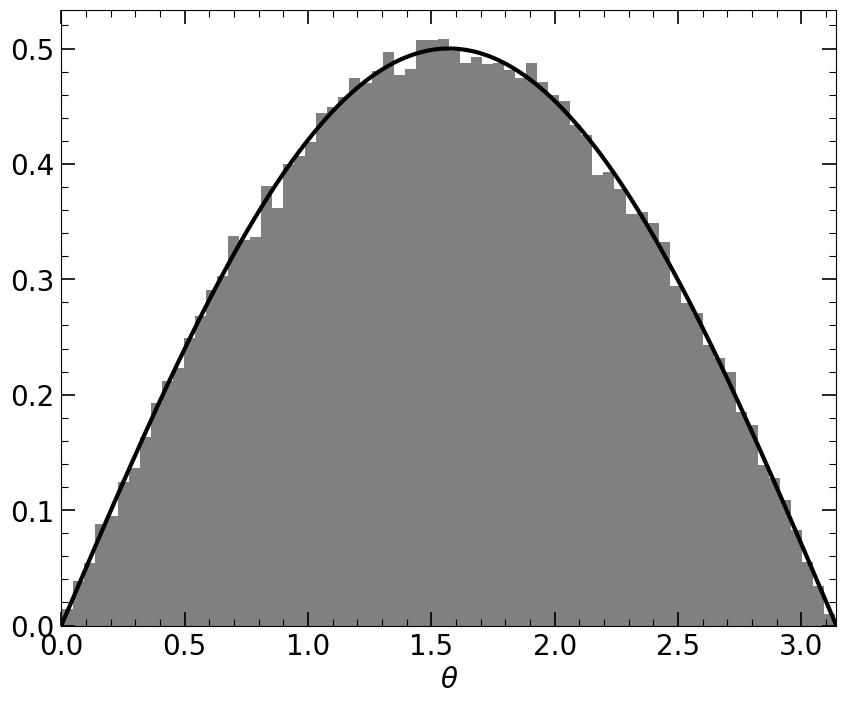

In [232]:
theta_init = pdf_initialiser(pdf_theta, theta_bounds[0], theta_bounds[1])

sampled_theta = pdf_sampler(theta_init[0],
                            theta_init[2][0], theta_init[3][0], theta_init[2][1], theta_init[3][1],
                            size=size, **theta_init[4])
fig, ax = sampler_diagnostic_plot(theta_init[0], theta_init[1][0], sampled_x=sampled_theta, **theta_init[4],
                                  color_plot='black', color_hist='gray', x_label=r'$\theta$', quantiles=[])

ax.autoscale(axis='x', tight=True)

figures.append(fig)
figure_names.append('pdf_theta')

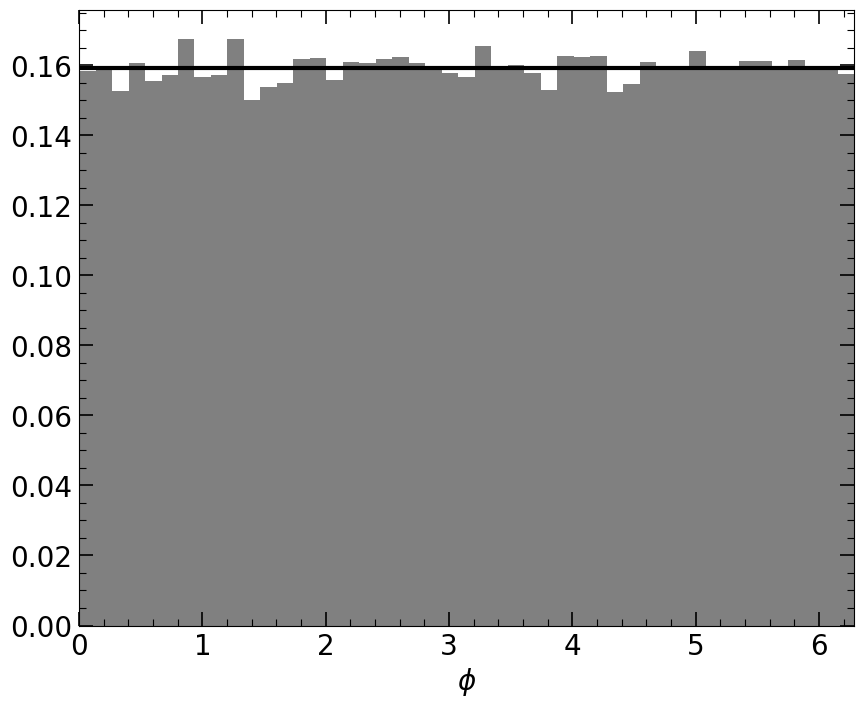

In [233]:
phi_init = pdf_initialiser(pdf_phi, phi_bounds[0], phi_bounds[1])

sampled_phi = pdf_sampler(phi_init[0],
                          phi_init[2][0], phi_init[3][0], phi_init[2][1], phi_init[3][1],
                          size=size, **phi_init[4])
fig, ax = sampler_diagnostic_plot(phi_init[0], phi_init[1][0], sampled_x=sampled_phi, **phi_init[4],
                                  color_plot='black', color_hist='gray', x_label=r'$\phi$', quantiles=[])

ax.autoscale(axis='x', tight=True)

figures.append(fig)
figure_names.append('pdf_phi')

In [234]:
if save_fig:
    for fig, name in zip(figures, figure_names):
        fig.savefig(name, dpi=dpi, bbox_inches='tight')
    
    figures = []
    figure_names = []

# Generate the plummer distribution

## Generate the points

In [15]:
# Generate points in spherical coordinates
spherical_positions = generate_spherical_points(pdf_r, r_bounds,
                                                pdf_theta, theta_bounds,
                                                pdf_phi, phi_bounds,
                                                size=N,
                                                pdf_r_args=dict(rho_0=rho_0, R_s=R_s, R_vir=R_vir, M_tot=M_tot))

# Compute the potential at each sampled radius
# This makes the computation of the velocities PDF faster
phi_R = [potential(R, rho_0, R_s, R_vir, value=True) for R in spherical_positions[:, 0]]

spherical_velocities = np.stack([generate_spherical_points(pdf_v, [0, (-2 * PHI) ** 0.5],
                                                           pdf_theta, theta_bounds,
                                                           pdf_phi, phi_bounds,
                                                           size=1, # Sample one velocity for each position
                                                           pdf_r_args=dict(R=R, rho_0=rho_0, R_s=R_s, R_vir=R_vir, phi_R=PHI)).squeeze()
                                                           for R, PHI in tqdm(zip(spherical_positions[:, 0], phi_R), total=len(spherical_positions))],
                                                           axis=0)

print(spherical_positions, spherical_velocities, sep='\n\n')

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_56311/4084278498.py:16: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)
100%|██████████| 10000/10000 [11:00<00:00, 15.14it/s]

[[16.34898788  0.56633841  3.10438716]
 [ 8.4322971   1.58800768  4.28226042]
 [ 4.37473292  1.77841384  3.14823036]
 ...
 [16.88336889  2.6649236   4.88694349]
 [ 5.35060162  1.85891686  2.08731048]
 [ 8.01988113  0.67293365  2.66626434]]

[[0.7063208  2.83900982 6.22922996]
 [1.02244725 1.45043161 0.42663945]
 [1.71202145 2.45855442 0.68664265]
 ...
 [1.04999955 1.32192911 6.13865733]
 [0.88575877 1.59341196 1.92694421]
 [1.08663739 0.62959496 4.19647365]]


In [16]:
# Convert points in cartesian coordinates
cartesian_positions = spherical_to_cartesian(spherical_positions)
cartesian_velocities = spherical_to_cartesian(spherical_velocities)

print(cartesian_positions, cartesian_velocities, sep='\n\n')

[[ -8.76590921   0.32629053  13.79644066]
 [ -3.51564299  -7.66308213  -0.14512407]
 [ -4.28069032  -0.0284144   -0.90176003]
 ...
 [  1.34532381  -7.6287474  -15.00134867]
 [ -2.53348459   4.46081228  -1.52037739]
 [ -4.44451558   2.28753587   6.2715193 ]]

[[ 0.21016791 -0.0113507  -0.67423266]
 [ 0.92406225  0.42004163  0.12276963]
 [ 0.83567188  0.6850064  -1.32794435]
 ...
 [ 1.00704119 -0.14656757  0.25862143]
 [-0.30875539  0.82996234 -0.02003029]
 [-0.31564864 -0.5565516   0.87829213]]


## Relevant quantities

In [17]:
min_sampled_r = np.min(spherical_positions[:, 0]) # Minimum sampled radius
max_sampled_r = np.max(spherical_positions[:, 0]) # Maximum sampled radius
mean_sampled_r = np.mean(spherical_positions[:, 0]) # Mean sampled radius
smoothing_length = 0.1 * R_vir / N ** (1 / 3) # Smoothing lenght of the treecode: 10% of the average separation between particles

max_esc_v = (-2 * np.min(phi_R)) ** 0.5 # Maximum escape velocity relative to the minimum radius
smooth_esc_v = (-2 * potential(smoothing_length, rho_0, R_s, R_vir, value=True)) ** 0.5 # Escape velocity ad the smoothing lenght
max_sampled_v = np.max(spherical_velocities[:, 0]) # Maximum sampled (radial) velocity

max_circ_v = v_circ(r_bounds[1], rho_0, R_s, R_vir, value=True) # Circular velocity of the outermost possible particle
max_sampled_circ_v = v_circ(max_sampled_r, rho_0, R_s, R_vir, value=True) # Circular velocity of the outermost sampled particle
mean_sampled_circ_v = v_circ(mean_sampled_r, rho_0, R_s, R_vir, value=True) # Circular velocity of the mean sampled radius
virial_circ_v = v_circ(R_vir, rho_0, R_s, R_vir, value=True) # Circular velocity at the virial radius

# Minimum time scale of the (sampled) system
min_time = min_sampled_r / max_esc_v
smooth_time = smoothing_length / smooth_esc_v

# Maximum circular period
max_circ_time = 2 * np.pi * r_bounds[1] / max_circ_v
max_sampled_circ_time = 2 * np.pi * max_sampled_r / max_sampled_circ_v
mean_sampled_circ_time = 2 * np.pi * mean_sampled_r / mean_sampled_circ_v
virial_circ_time = 2 * np.pi * R_vir / virial_circ_v

# Dynamical time of the particle with the higher possible value
max_dyn_time = max_circ_time / 4
max_sampled_dyn_time = max_sampled_circ_time / 4
mean_sampled_dyn_time = mean_sampled_circ_time / 4
virial_dynamical_time = virial_circ_time / 4

summary_str = ("RADIUS\n"
               "Minimum sampled radius: {min_sampled_r}\n"
               "Maximum sampled radius: {max_sampled_r}\n"
               "Mean sampled radius: {mean_sampled_r}\n"
               "Maximum possible radius: {max_r}\n"
               "Smoothing lenght: {smoothing_lenght}\n\n"
               "ESCAPE VELOCITY\n"
               "Maximum escape velocity: {max_esc_v}\n"
               "Smoothing lenght escape velocity: {smooth_esc_v}\n"
               "Minimum time scale: {min_time}\n"
               "Smoothing length time scale: {smooth_time}\n\n"
               "Maximum sampled velocity: {max_sampled_v}\n\n"
               "CIRCULAR VELOCITY\n"
               "Maximum circular velocity: {max_circ_v}\n"
               "Maximum sampled circular velocity: {max_sampled_circ_v}\n"
               "Mean sampled circular velocity: {mean_sampled_circ_v}\n"
               "Virial circular velocity: {virial_circ_v}\n"
               "Maximum circular period: {max_circ_time}\n"
               "Maximum sampled circular period: {max_sampled_circ_time}\n"
               "Mean sampled circular period: {mean_sampled_circ_time}\n"
               "Virial circular period: {virial_circ_time}\n"
               "Maximum dynamical time: {max_dyn_time}\n"
               "Maximum sampled dynamical time: {max_sampled_dyn_time}\n"
               "Mean sampled dynamical time: {mean_sampled_dyn_time}\n"
               "Virial radius dynamical time: {virial_dynamical_time}\n\n").format(
                   min_sampled_r=min_sampled_r,
                   max_sampled_r=max_sampled_r,
                   mean_sampled_r=mean_sampled_r,
                   max_r=r_bounds[1],
                   smoothing_lenght=np.format_float_scientific(smoothing_length, 3),
                   max_esc_v=max_esc_v,
                   smooth_esc_v=smooth_esc_v,
                   max_sampled_v=max_sampled_v,
                   min_time=np.format_float_scientific(min_time, 3),
                   smooth_time=np.format_float_scientific(smooth_time, 3),
                   max_circ_v=max_circ_v,
                   max_sampled_circ_v=max_sampled_circ_v,
                   mean_sampled_circ_v=mean_sampled_circ_v,
                   virial_circ_v=virial_circ_v,
                   max_circ_time=np.format_float_scientific(max_circ_time, 3),
                   max_sampled_circ_time=np.format_float_scientific(max_sampled_circ_time, 3),
                   mean_sampled_circ_time=np.format_float_scientific(mean_sampled_circ_time, 3),
                   virial_circ_time=np.format_float_scientific(virial_circ_time, 3),
                   max_dyn_time=np.format_float_scientific(max_dyn_time, 3),
                   max_sampled_dyn_time=np.format_float_scientific(max_sampled_dyn_time, 3),
                   mean_sampled_dyn_time=np.format_float_scientific(mean_sampled_dyn_time, 3),
                   virial_dynamical_time=np.format_float_scientific(virial_dynamical_time, 3))

print(summary_str)

RADIUS
Minimum sampled radius: 0.01343104393411454
Maximum sampled radius: 228.98932700351244
Mean sampled radius: 18.790992280093622
Maximum possible radius: 250
Smoothing lenght: 1.160e-01

ESCAPE VELOCITY
Maximum escape velocity: 4.93144884582506
Smoothing lenght escape velocity: 4.809583483721349
Minimum time scale: 2.724e-03
Smoothing length time scale: 2.413e-02

Maximum sampled velocity: 3.687662173844095

CIRCULAR VELOCITY
Maximum circular velocity: 0.38600360606577616
Maximum sampled circular velocity: 0.40331563323626224
Mean sampled circular velocity: 1.1558808030665642
Virial circular velocity: 1.0583325482739228
Maximum circular period: 4.069e+03
Maximum sampled circular period: 3.567e+03
Mean sampled circular period: 1.021e+02
Virial circular period: 1.484e+02
Maximum dynamical time: 1.017e+03
Maximum sampled dynamical time: 8.918e+02
Mean sampled dynamical time: 2.554e+01
Virial radius dynamical time: 3.711e+01




/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_56311/4084278498.py:16: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


## Drifting velocity

If you want add a drifting velocity to the plummer sphere.

In [18]:
# Compute the velocity of the center of mass
cm_vel = get_qt_center_of_mass(cartesian_velocities, m)

print("CM velocity:", cm_vel)

CM velocity: [ 0.00278751 -0.00371513  0.01216183]


In [19]:
# Whether to add a drifting velocity or not or not
add_drifting = False

# Define the drifting velocity in cartesian components
v_drift = -cm_vel

if add_drifting:
    # Print velocities before adding drift
    print(cartesian_velocities, '\n')

    # Add drifting velocity
    for i in range(3):
        cartesian_velocities[:, i] += v_drift[i]

    # Print velocities after drift have been added
    print(cartesian_velocities)

In [20]:
# Compute again the velocity of the center of mass
cm_vel = get_qt_center_of_mass(cartesian_velocities, m)

print("CM velocity:", cm_vel)

CM velocity: [ 0.00278751 -0.00371513  0.01216183]


## Perturber

Add a perturber to the distribution.

In [21]:
# Define the mass of the perturber
perturber_mass = M_tot / 50

print("Mass of a particle: {m}\n"
      "Mass of the perturber: {M}".format(m=m,
                                          M=perturber_mass))

Mass of a particle: 0.0037250828686530924
Mass of the perturber: 0.7450165737306185


### From _spherical coordinates_

In [22]:
# Toggle for the perturber spherical coordinates
spherical_perturber = False

if spherical_perturber:
      # Position of the perturber in spherical coordinates
      rad = 5 * R_s
      perturber_pos = np.array([rad, 3 * np.pi / 4, 7 * np.pi / 6])

      # Generate the radial velocity
      v_rad = 0.85 # Fraction of the escape velocity
      v_rad *= (-2 * potential(rad, rho_0, R_s, R_vir, value=True)) ** 0.5

      # Velocity of the perturber in spherical coordinates
      perturber_vel = np.array([v_rad, np.pi / 6, 11 * np.pi / 6])

      # Convert into cartesian coordinates (don't squeeze them)
      # They have shape (1, 3)
      perturber_pos = spherical_to_cartesian(np.expand_dims(perturber_pos, axis=0))
      perturber_vel = spherical_to_cartesian(np.expand_dims(perturber_vel, axis=0))

      print("CARTESIAN COORDINATES\n\n"
            "Perturber position: {perturber_pos}\n"
            "Perturber velocity: {perturber_vel}".format(perturber_pos=perturber_pos,
                                                         perturber_vel=perturber_vel))

### From _cartesian coordinates_

Estimation of the decay time of the perturber. See Binney and Tremaine, Galactic Dynamics 2nd Edition, 8.1.1.a

$$t_{fric} = \frac{1.17}{\ln \Lambda} \frac{r_i^2 v_c}{G M}$$

In [23]:
# Togggle for the perturber in cartesian coordinates
cartesian_perturber = False

if cartesian_perturber:
    # Position of the perturber in cartesian coordinates
    perturber_pos = np.array([R_vir * (1 / 2) ** 0.5, R_vir * (1 / 2) ** 0.5, 0])

    # Estimate the typical squared velocity of a particle to use it
    # as reference for the perturber
    v_squared_mean = np.mean(spherical_velocities[:, 0] ** 2)

    # Velocity of the perturber in cartesian coordinates
    # v_rad = v_circ(R_vir, rho_0, R_s, R_vir, value=True)
    v_rad = (-2 * potential(R_vir, rho_0, R_s, R_vir, value=True)) ** 0.5
    perturber_vel = np.array([-0.75 * v_rad, 0, 0])

    # Estimate of the decay time of the perturber
    t_fric = 1.17 * (R_vir ** 2) * v_circ(R_vir, rho_0, R_s, R_vir, value=True) / (3 * perturber_mass)

    # Make them of shape (1, 3)
    perturber_pos = np.expand_dims(perturber_pos, axis=0)
    perturber_vel = np.expand_dims(perturber_vel, axis=0)

    print("CARTESIAN COORDINATES\n\n"
            "Perturber position: {perturber_pos}\n"
            "Perturber velocity: {perturber_vel}".format(perturber_pos=perturber_pos,
                                                         perturber_vel=perturber_vel))
    
    print("\n\nDecay time:", t_fric)

### Add the perturber to the distribution

In [24]:
# Easy if you haven't squeezed perturber_pos and perturber_vel (don't squeeze them)
if spherical_perturber or cartesian_perturber:
    cartesian_positions = np.append(cartesian_positions, perturber_pos, axis=0)
    cartesian_velocities = np.append(cartesian_velocities, perturber_vel, axis=0)

    # Define the perturber index
    perturber_index = N

    # Update the number of particles
    N += 1
    masses_array.append(perturber_mass)

    print("ADDED A PERTURBER\n")

# Print the shape of the matrixes of positions and velocities for diagnostic purpose
print("Positions shape: {ps}\n"
      "Velocities shape: {vs}".format(ps=cartesian_positions.shape,
                                      vs=cartesian_velocities.shape))

Positions shape: (10000, 3)
Velocities shape: (10000, 3)


## Plot the points

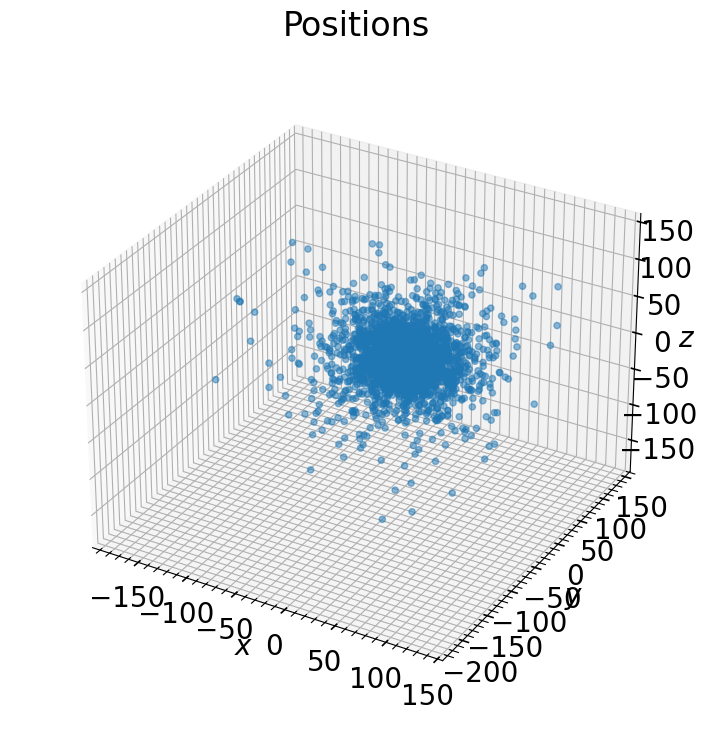

In [25]:
# Initialise a 3D plot
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(projection='3d', computed_zorder=False)
ax.set_box_aspect(None, zoom=0.9) # To prevent z axis label to be cut off

ax.set_title("Positions")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

ax.scatter(cartesian_positions[:, 0], cartesian_positions[:, 1], cartesian_positions[:, 2],
           alpha=0.5, zorder=0)

# Plot the perturber if there is one
if spherical_perturber or cartesian_perturber:
    ax.scatter(cartesian_positions[perturber_index, 0],
               cartesian_positions[perturber_index, 1],
               cartesian_positions[perturber_index, 2],
               color='red', zorder=1)

plt.show()

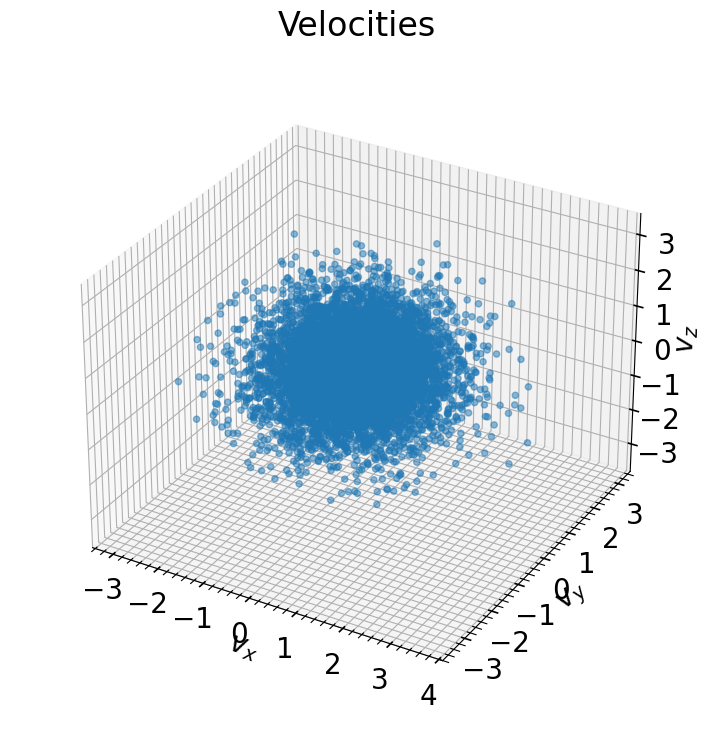

In [26]:
# Initialise a 3D plot
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(projection='3d', computed_zorder=False)
ax.set_box_aspect(None, zoom=0.9) # To prevent z axis label to be cut off

ax.set_title("Velocities")

ax.set_xlabel("$v_x$")
ax.set_ylabel("$v_y$")
ax.set_zlabel("$v_z$")

ax.scatter(cartesian_velocities[:, 0], cartesian_velocities[:, 1], cartesian_velocities[:, 2],
           alpha=0.5, zorder=0)

# Plot the perturber if there is one
if spherical_perturber or cartesian_perturber:
    ax.scatter(cartesian_velocities[perturber_index, 0],
               cartesian_velocities[perturber_index, 1],
               cartesian_velocities[perturber_index, 2],
               color='red', zorder=1)

plt.show()

## Build the _treecode_ input file

In [27]:
# Variables to store the string lines to be put in the input file
masses = []
positions = []
velocities = []

# Fill the variables
for i in range(N):
    masses.append('\n' + str(masses_array[i]))
    positions.append('\n' + ' '.join(str(coord) for coord in cartesian_positions[i]))
    velocities.append('\n' + ' '.join(str(coord) for coord in cartesian_velocities[i]))

In [ ]:
# Whether to make an input file or not
make_input = False

if make_input:
    # Create or overwrite the input file
    file_name = "input.txt"

    input_file = open(file_name, 'w')

    # Write a file in the proper format for the treecode program:
    #
    # N
    # n_dim
    # t_0
    # m_1
    # ..
    # m_N
    # x_1, y_1, z_1
    # ...
    # x_N, y_N, z_N
    # vx_1, vy_1, vz_1
    # ...
    # vx_N, vy_N, vz_N
    input_file.write(str(N))
    input_file.write('\n' + str(3)) # Number of dimensions
    input_file.write('\n' + str(t0))
    
    input_file.writelines(masses)
    input_file.writelines(positions)
    input_file.writelines(velocities)

    input_file.close()